In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import seaborn as sns
from matplotlib import pylab as plt
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['agg.path.chunksize'] = 10000

pd.set_option('display.max_columns', None)

In [116]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


import statsmodels.tsa.api as smt
import scipy.stats as scs

In [117]:
from scipy import linalg
from statsmodels.tsa.stattools import acf as sm_acf
from statsmodels.tsa.stattools import acovf as sm_acovf
from statsmodels.tsa.stattools import pacf as sm_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox as sm_acorr_ljungbox

In [3]:
df = pd.read_csv('data/weather_madrid_LEMD_1997_2015.csv')

# Exploration

In [4]:
rename_dict =  {'CET'                           :'date',
                'Max TemperatureC'              :'temperature_max',
                'Mean TemperatureC'             :'temperature',
                'Min TemperatureC'              :'temperature_min',
                'Dew PointC'                    :'dewpoint_max',
                'MeanDew PointC'                :'dewpoint',
                'Min DewpointC'                 :'dewpoint_min',
                'Max Humidity'                  :'humidity_max',
                ' Mean Humidity'                :'humidity',
                ' Min Humidity'                 :'humidity_min',
                ' Max Sea Level PressurehPa'    :'pressure_max',
                ' Mean Sea Level PressurehPa'   :'pressure',
                ' Min Sea Level PressurehPa'    :'pressure_min',
                ' Max VisibilityKm'             :'visibility_max',
                ' Mean VisibilityKm'            :'visibility',
                ' Min VisibilitykM'             :'visibility_min',
                ' Max Wind SpeedKm/h'           :'windspeed_max',
                ' Mean Wind SpeedKm/h'          :'windspeed',
                ' Max Gust SpeedKm/h'           :'gustspeed',      
                'Precipitationmm'               :'precipitation',
                ' CloudCover'                   :'cloudcover',
                ' Events'                       :'events',
                'WindDirDegrees'                :'winddirection',
                }
df.rename(columns=rename_dict, inplace=True)

In [5]:
# Dates are strings:
df.date[0]

'1997-1-1'

In [6]:
# Date conversions:
df.date = pd.to_datetime(df.date)
df['DOY'] = (df.date.dt.dayofyear / (365+df.date.dt.is_leap_year)) # as decimal in (0,1]
df['Year_f'] = df.date.dt.year + df.DOY

In [7]:
len(df)

6812

In [8]:
[test_df,df] = [df.loc[df.date.dt.year>=2013],df.loc[df.date.dt.year<2013]]

In [9]:
print(len(df),len(test_df))

5717 1095


In [10]:
dfD = df.set_index('date',drop=False)
dfFull = pd.DataFrame(index=pd.date_range(start=df.date.min(),end=df.date.max()),columns=df.columns)
dfFull.update(dfD)
dfFull.date = pd.date_range(start=df.date.min(),end=df.date.max())   
for col in dfFull:
    dfFull[col] = dfFull[col].astype('float64' if dfD[col].dtype in ['int64'] else dfD[col].dtype)
dfFull['DOY'] = (dfFull.date.dt.dayofyear / (365+dfFull.date.dt.is_leap_year)) # as decimal in (0,1]
dfFull['Year_f'] = dfFull.date.dt.year + dfFull.DOY

In [11]:
dfFull.iloc[1143:1152]

,date,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,events,winddirection,DOY,Year_f
2000-02-18,2000-02-18,18.0,10.0,2.0,6.0,4.0,0.0,87.0,71.0,42.0,1028.0,1026.0,1024.0,NaN,NaN,NaN,10.0,3.0,NaN,0.0,NaN,NaN,18.0,0.133880,2000.133880
2000-02-19,2000-02-19,20.0,10.0,1.0,5.0,2.0,-1.0,87.0,66.0,32.0,1025.0,1024.0,1021.0,NaN,NaN,NaN,19.0,3.0,NaN,0.0,NaN,NaN,33.0,0.136612,2000.136612
2000-02-20,2000-02-20,18.0,9.0,1.0,5.0,2.0,-1.0,87.0,65.0,32.0,1025.0,1023.0,1021.0,NaN,NaN,NaN,8.0,3.0,NaN,0.0,NaN,NaN,328.0,0.139344,2000.139344
2000-02-21,2000-02-21,17.0,8.0,0.0,5.0,1.0,-2.0,93.0,66.0,36.0,1026.0,1024.0,1023.0,NaN,NaN,NaN,11.0,5.0,NaN,0.0,NaN,NaN,334.0,0.142077,2000.142077
2000-02-22,2000-02-22,16.0,8.0,1.0,4.0,2.0,-1.0,87.0,69.0,36.0,1024.0,1023.0,1022.0,10.0,9.0,9.0,6.0,3.0,NaN,0.0,6.0,NaN,359.0,0.144809,2000.144809
2000-02-23,2000-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.147541,2000.147541
2000-02-24,2000-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150273,2000.150273
2000-02-25,2000-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.153005,2000.153005
2000-02-26,2000-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155738,2000.155738


In [12]:
for col in dfFull:
    print((col,dfFull[col].dtype))

('date', dtype('<M8[ns]'))
('temperature_max', dtype('float64'))
('temperature', dtype('float64'))
('temperature_min', dtype('float64'))
('dewpoint_max', dtype('float64'))
('dewpoint', dtype('float64'))
('dewpoint_min', dtype('float64'))
('humidity_max', dtype('float64'))
('humidity', dtype('float64'))
('humidity_min', dtype('float64'))
('pressure_max', dtype('float64'))
('pressure', dtype('float64'))
('pressure_min', dtype('float64'))
('visibility_max', dtype('float64'))
('visibility', dtype('float64'))
('visibility_min', dtype('float64'))
('windspeed_max', dtype('float64'))
('windspeed', dtype('float64'))
('gustspeed', dtype('float64'))
('precipitation', dtype('float64'))
('cloudcover', dtype('float64'))
('events', dtype('O'))
('winddirection', dtype('float64'))
('DOY', dtype('float64'))
('Year_f', dtype('float64'))


In [13]:
nullCells = dfFull.isnull()

In [14]:
print(sum(nullCells.temperature))
print(sum(nullCells.temperature[:pd.Timestamp('2000-02-22')]))
print(sum(nullCells.temperature[:pd.Timestamp('2004-02-01')]))

130
0
130


In [15]:
df.head()

,date,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,events,winddirection,DOY,Year_f
0,1997-01-01,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,NaN,229,0.002740,1997.002740
1,1997-01-02,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.0,5.0,Rain,143,0.005479,1997.005479
2,1997-01-03,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,NaN,0.0,6.0,Rain-Snow,256,0.008219,1997.008219
3,1997-01-04,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.0,2.0,NaN,284,0.010959,1997.010959
4,1997-01-05,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,NaN,0.0,7.0,Snow,2,0.013699,1997.013699


In [16]:
df.describe()

,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,winddirection,DOY,Year_f
count,5715.000000,5714.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5717.000000,5717.000000,5717.000000,4777.000000,4777.000000,4777.000000,5717.000000,5717.000000,2682.000000,5717.000000,4630.000000,5717.000000,5717.000000,5717.000000
mean,20.875941,14.519776,8.587402,8.030796,4.902012,1.415923,81.137533,58.456868,36.221347,1020.398461,1018.003848,1015.529823,11.010467,9.919824,8.504919,21.658037,9.006297,43.663311,0.020388,3.239525,195.519853,0.506633,2005.086658
std,8.841317,7.565159,6.832758,4.783309,4.694278,4.958462,17.396003,19.629104,19.221618,6.068196,6.394319,6.801470,4.675784,3.066143,3.895358,9.784401,5.081384,12.337341,0.507565,1.792508,120.985340,0.288340,4.629175
min,0.000000,-3.000000,-10.000000,-12.000000,-15.000000,-22.000000,16.000000,15.000000,4.000000,996.000000,990.000000,965.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,-1.000000,0.002732,1997.002740
25%,13.000000,8.000000,3.000000,5.000000,2.000000,-2.000000,68.000000,42.000000,20.000000,1017.000000,1014.000000,1012.000000,10.000000,10.000000,7.000000,13.000000,5.000000,35.000000,0.000000,2.000000,60.000000,0.257534,2001.180822
50%,20.000000,14.000000,9.000000,8.000000,5.000000,2.000000,87.000000,59.000000,33.000000,1020.000000,1018.000000,1016.000000,10.000000,10.000000,10.000000,21.000000,8.000000,42.000000,0.000000,3.000000,223.000000,0.509589,2005.175342
75%,29.000000,21.000000,14.000000,12.000000,8.000000,5.000000,94.000000,75.000000,49.000000,1024.000000,1022.000000,1020.000000,10.000000,10.000000,10.000000,27.000000,11.000000,52.000000,0.000000,5.000000,299.000000,0.756164,2009.087671
max,41.000000,32.000000,28.000000,20.000000,16.000000,14.000000,100.000000,100.000000,100.000000,1041.000000,1040.000000,1038.000000,31.000000,31.000000,31.000000,182.000000,39.000000,103.000000,32.000000,8.000000,360.000000,1.000000,2013.000000


In [17]:
# helper plot function
def plot_series(dfs, cols, *args, **kwargs):
    if not(isinstance(dfs,list)):
        plot_series([dfs],cols,*args,**kwargs)
    elif not(isinstance(cols,list)):
        plot_series(dfs,[cols],*args, **kwargs)
    else:
        plt.figure(figsize=(16,6))
        if ('xlabel' in kwargs):
            plt.xlabel(kwargs.pop('xlabel'))
        if ('ylabel' in kwargs):
            plt.ylabel(kwargs.pop('ylabel'))
        elif (len(cols)==1):
            plt.ylabel(cols[0])
        if (len(dfs)<len(cols)):
            assert (len(dfs)==1)
            dfs = dfs*len(cols)
        elif (len(dfs)>len(cols)):
            assert (len(cols)==1)
            cols = cols*len(dfs)
        for j in range(len(dfs)):
            try:
                t=dfs[j].date
                plt.xlabel('date')
            except:
                t=dfs[j].index
            if (isinstance(dfs[j],pd.DataFrame)):
                series = dfs[j][cols[j]]
            else:
                series = pd.Series(dfs[j])
                cols[j] = (cols[j] if (cols[j]) else series.name)
            plt.plot(t,series,label=cols[j],*args,**kwargs)
        plt.legend()
        plt.show()

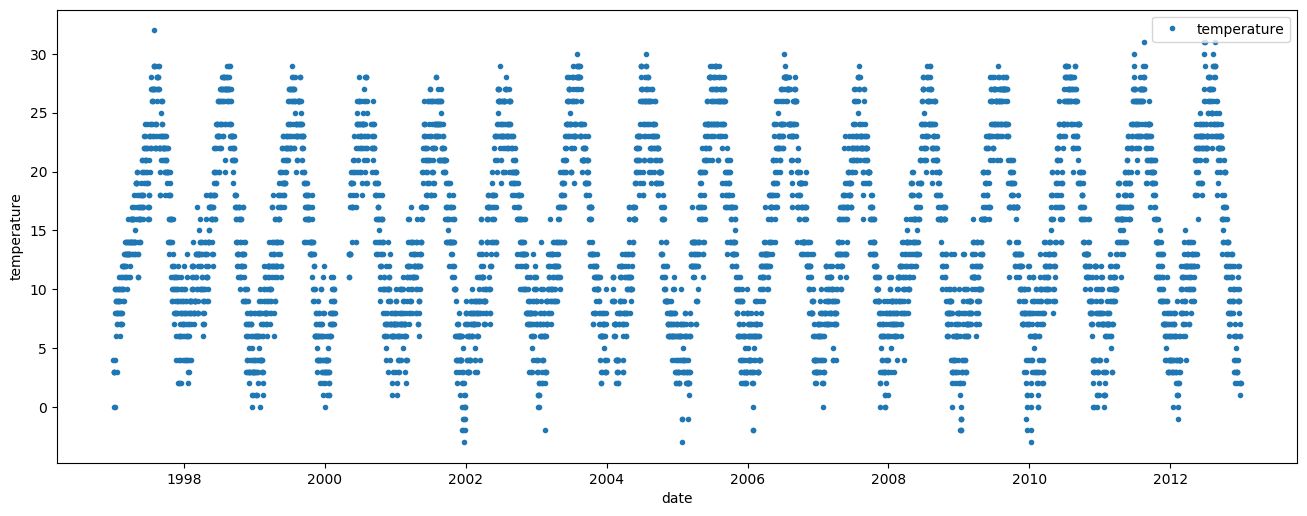

In [18]:
plot_series(df,'temperature','.')

Observations:
    
1) Seasonality! (of course)

2) No obvious trend, but we'll look

3) Missing Data

4) Measurements are integers, but the frequency distribution is unnatural. Unexpectedly few data points have values at odd integer multiples of 5... why?


Discretization of Values:

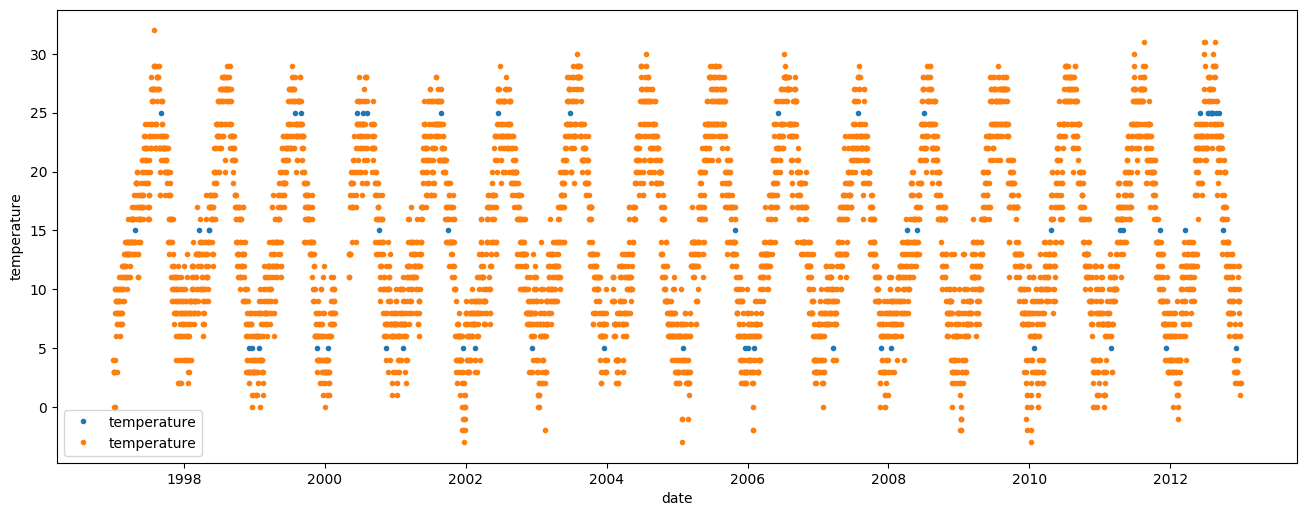

In [19]:
odd5 = ((~(df.temperature%5).astype(bool)) & ((df.temperature%2).astype(bool)))
plot_series([df.loc[odd5],df.loc[~odd5]],'temperature','.')

Text(0, 0.5, 'Value Count')

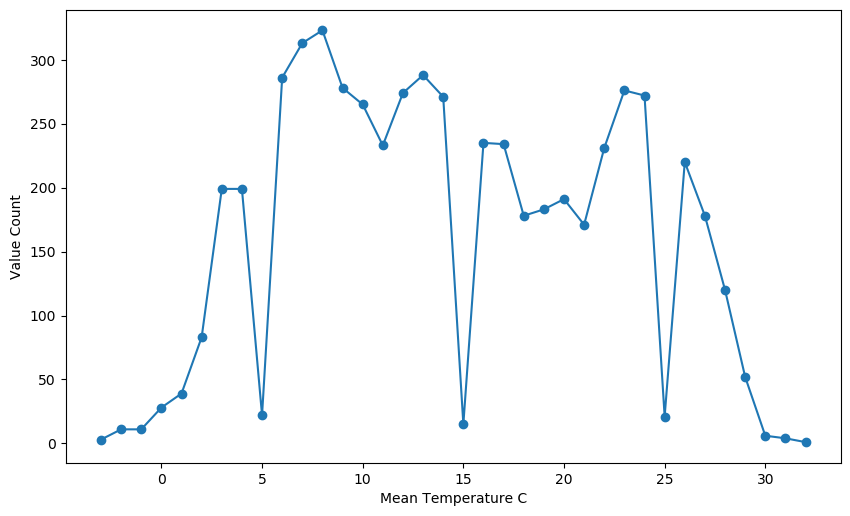

In [20]:
VC = df.temperature.value_counts().sort_index()
plt.plot(VC.index,VC,'-o')
plt.xlabel('Mean Temperature C')
plt.ylabel('Value Count')

Temperatures ending in '5' are suppressed by ~ 10x

Probably not due to binning

Also, there exists no similar structure within temperature_max or temperature_min:

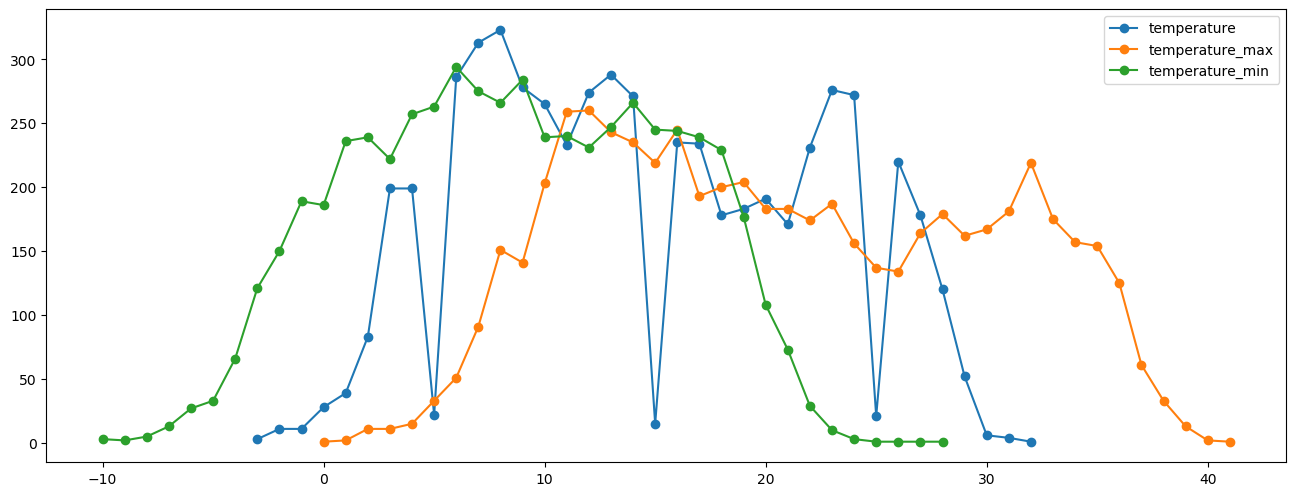

In [21]:
VC = df.temperature.value_counts().sort_index()
cols4plot = ['temperature','temperature_max','temperature_min']
plot_series([df[col].value_counts().sort_index() for col in cols4plot],None,'-o')

Text(0, 0.5, 'MeanTemperature')

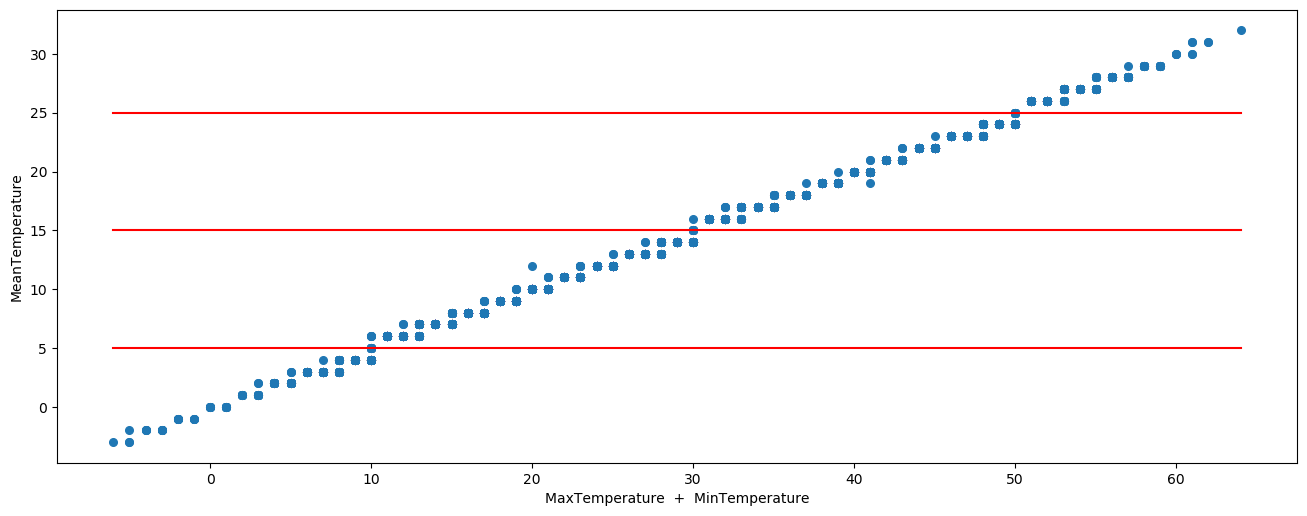

In [22]:
plt.figure(figsize=(16,6))
plt.plot((1.0*(df.temperature_max+df.temperature_min)),df.temperature,'.',markersize=11)
plt.plot([2*df.temperature.min(),2*df.temperature.max()],[5,5],'r')
plt.plot([2*df.temperature.min(),2*df.temperature.max()],[15,15],'r')
plt.plot([2*df.temperature.min(),2*df.temperature.max()],[25,25],'r')
plt.xlabel('MaxTemperature  +  MinTemperature')
plt.ylabel('MeanTemperature')

## Missing Data

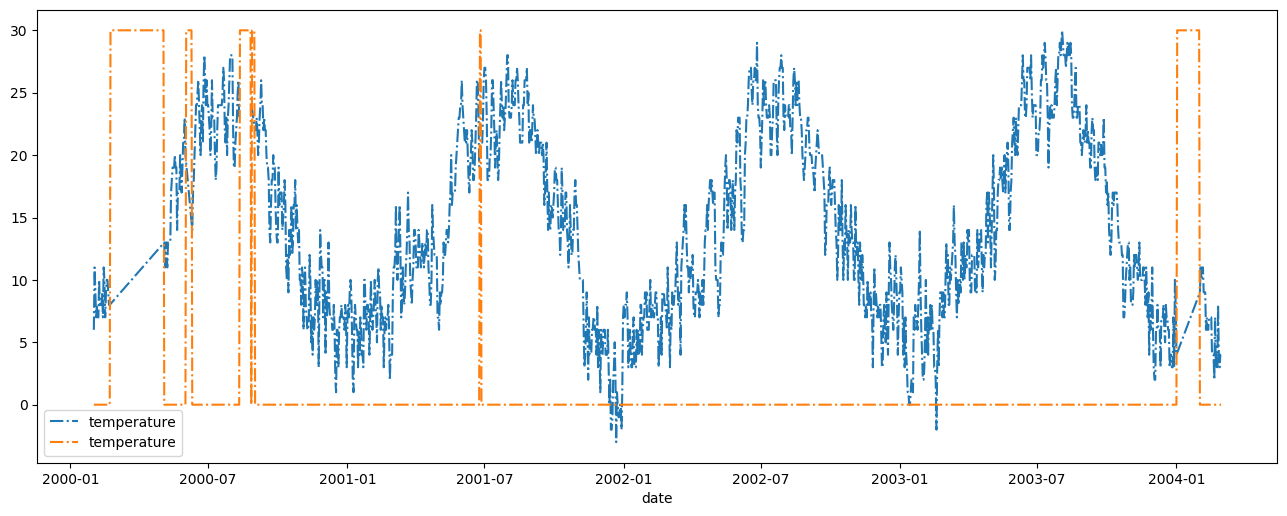

In [23]:
timeBounds = [pd.Timestamp('2000-02-01'),pd.Timestamp('2004-03-01')]
roughPatch_full = (dfFull.date >= timeBounds[0]) & (dfFull.date < timeBounds[1])
roughPatch_orig = (df.date >= timeBounds[0]) & (df.date < timeBounds[1])
plot_series([df[roughPatch_orig],dfFull[roughPatch_full].temperature.isnull()*30],['temperature',None],'-.')

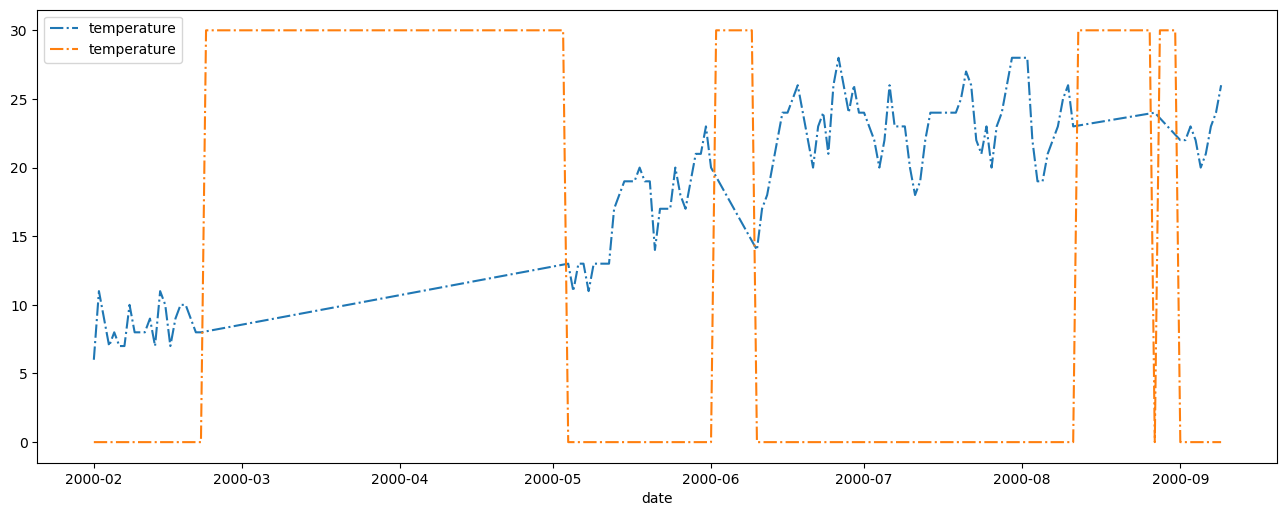

In [24]:
timeBounds = [pd.Timestamp('2000-02-01'),pd.Timestamp('2000-09-10')]
calendarSelection_full = (dfFull.date >= timeBounds[0]) & (dfFull.date < timeBounds[1])
calendarSelection_orig = (df.date >= timeBounds[0]) & (df.date < timeBounds[1])
plot_series([df[calendarSelection_orig&(~df.temperature.isnull())],dfFull[calendarSelection_full].temperature.isnull()*30],
                 ['temperature',None],'-.')

What to do about the missing data?

Some options:
    
One option: Select only the data starting at 2004 Feb 01. This is a substantial contiguous block to work with. With this choice, we are hypothesizing that weather patterns won't vary so much across years that our earliest data would become necessary to improve model generalization.

One interesting question: Can we do better by including the earliest data? And if so, how should we include that early data?

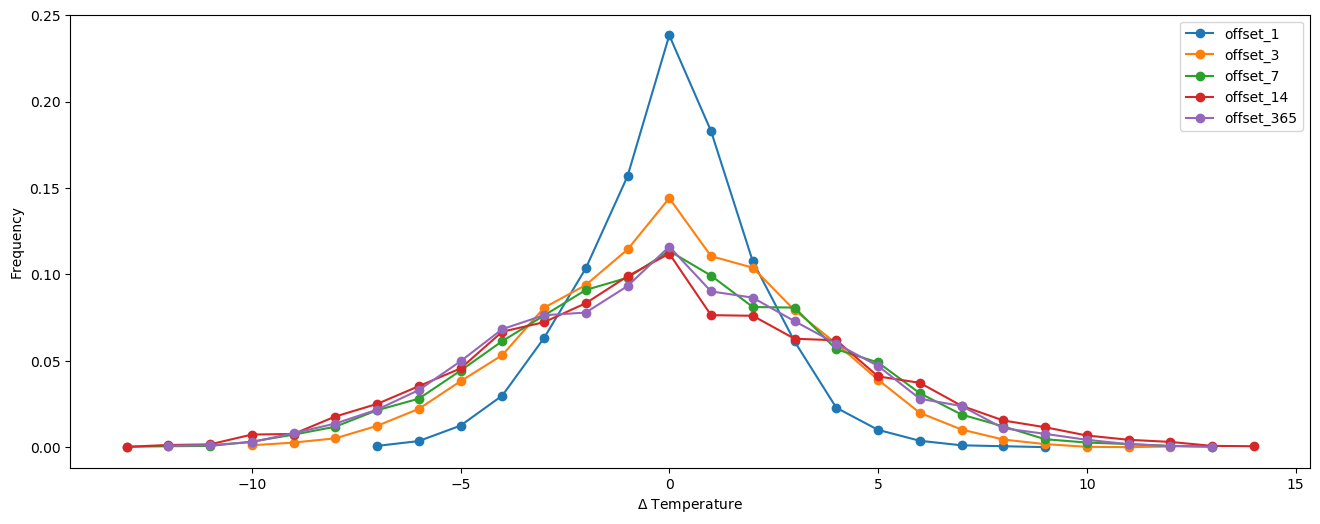

In [25]:
offsets = [1,3,7,14,365]
diff_ps = [dfFull.temperature.diff(oo).rename('offset_%d'%oo) for oo in offsets]
valueCount_ps = [dfFull.temperature.diff(oo).value_counts() for oo in offsets]
diffsHistograms_List = [vcps.sort_index()/vcps.sum() for vcps in valueCount_ps]
names = ['offset_%d'%oo for oo in offsets]
plot_series(diffsHistograms_List,names,'-o',xlabel='$\Delta$ Temperature',ylabel='Frequency')

In [26]:
for j in range(len(offsets)):
    print((offsets[j],diff_ps[j].std()))

(1, 2.0385777901760145)
(3, 3.181073264639351)
(7, 3.8111573432752754)
(14, 4.267388359138504)
(365, 3.9329037203928263)


No handles with labels found to put in legend.


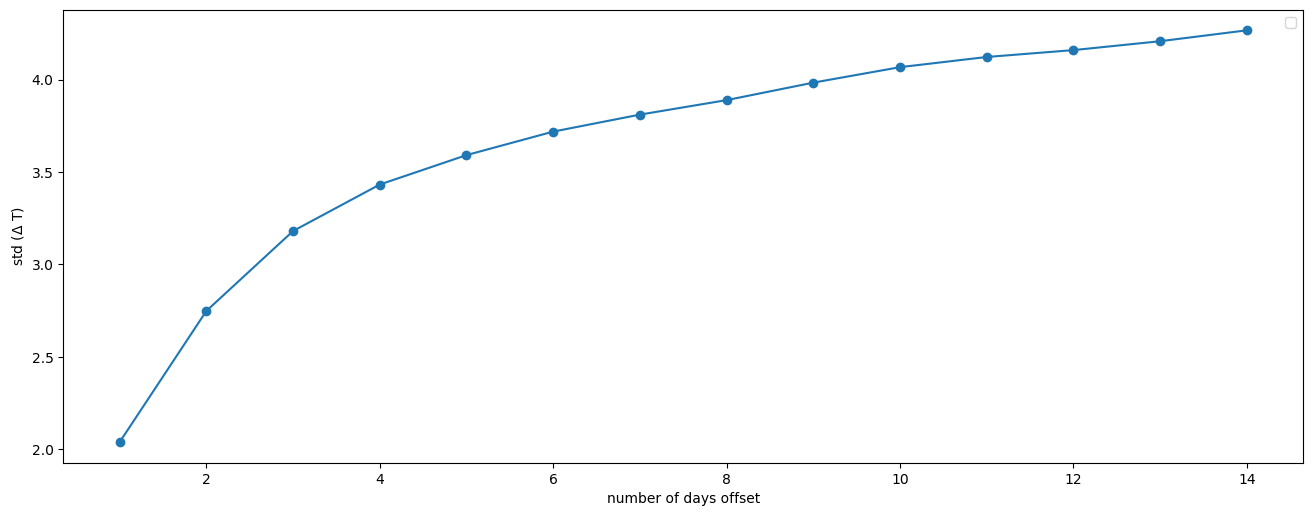

In [27]:
std_list = [dfFull.temperature.diff(oo).std() for oo in range(1,15)]
plot_series(pd.Series(std_list,index=list(range(1,15))),None,
                 '-o',xlabel='number of days offset',ylabel='std ($\Delta$ T)')

In [28]:
for j in range(len(offsets)):
    print((offsets[j],diff_ps[j].abs().mean()))

(1, 1.5284738041002277)
(3, 2.500877808988764)
(7, 3.020257178087018)
(14, 3.3666784702549575)
(365, 3.1281854761448553)


No handles with labels found to put in legend.


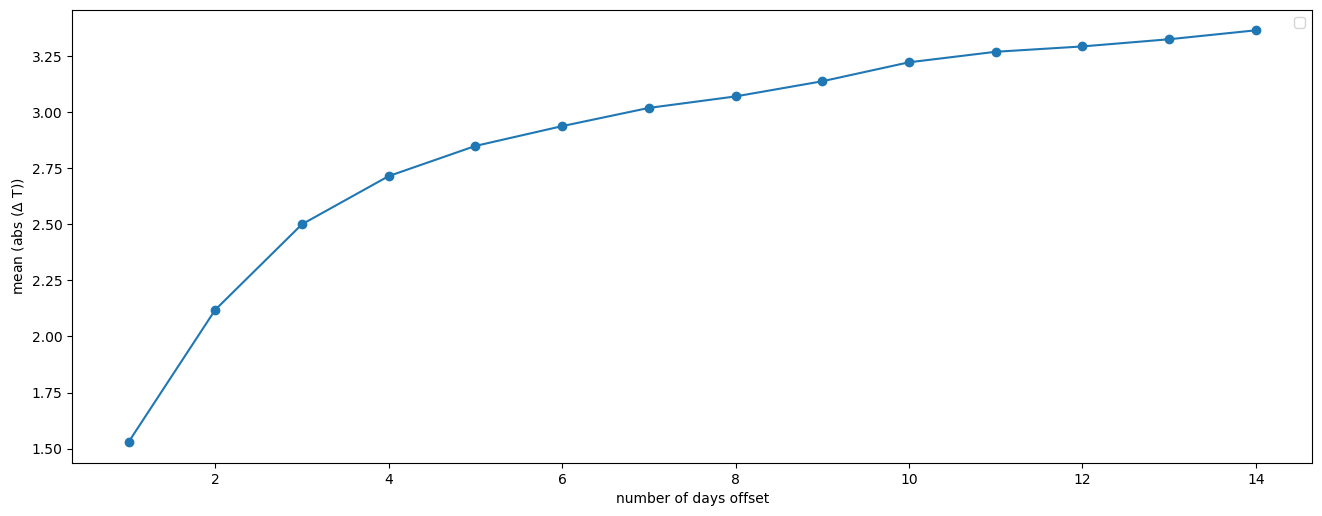

In [29]:
std_list = [dfFull.temperature.diff(oo).abs().mean() for oo in range(1,15)]
plot_series(pd.Series(std_list,index=list(range(1,15))),None,
                 '-o',xlabel='number of days offset',ylabel='mean (abs ($\Delta$ T))')

In [30]:
dfFull.temperature.diff(1).abs().mean()

1.5284738041002277

# Approach:

In [ ]:
Fit Trend

Fit Seasonality based on known period

Fit a predictive model to the residuals

## Investigate Trend

Is there a trend in this data?

In [31]:
completeYears = ~dfFull.temperature.isnull().groupby(dfFull.date.dt.year).any()
yearlyMeanTemperature = (dfFull.groupby(dfFull.date.dt.year)['temperature'].sum()/ \
        dfFull.groupby(dfFull.date.dt.year)['temperature'].count()).loc[completeYears]


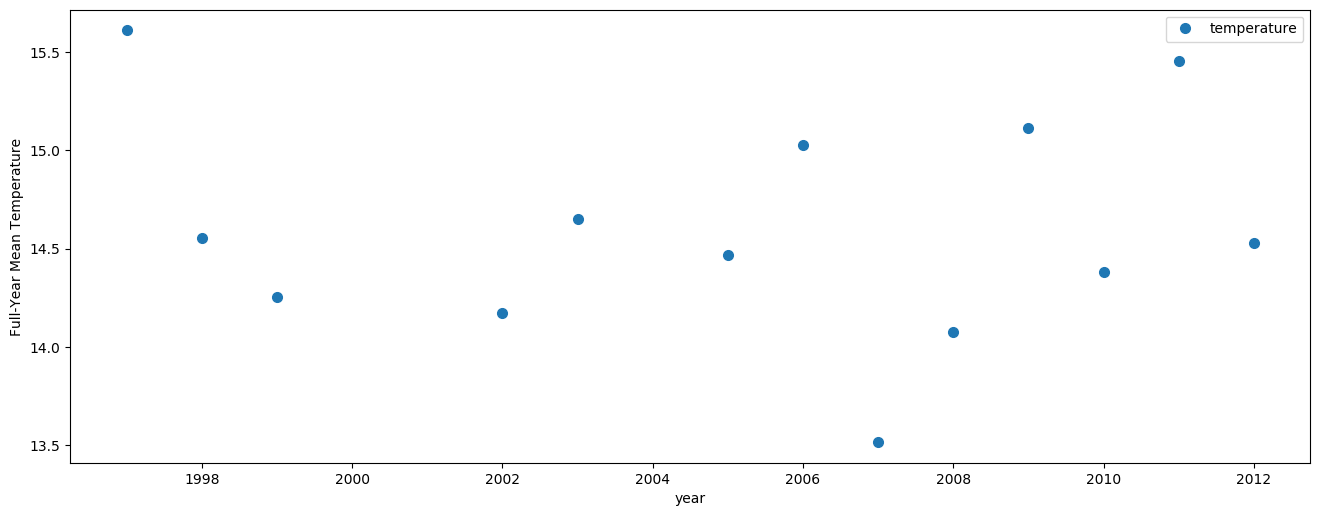

In [32]:
plot_series(yearlyMeanTemperature,None,'.',markersize=14,xlabel='year',ylabel='Full-Year Mean Temperature')

In [33]:
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html

In [34]:
sm_trendModel_validFullYears = OLS(yearlyMeanTemperature,sm.add_constant(yearlyMeanTemperature.index),missing='drop')
results = sm_trendModel_validFullYears.fit()
print(results.params)
print()
print(results.tvalues)
print()
print(results.t_test([0,1]))
print()
#print(results.HC0_se)

const    29.512935
x1       -0.007437
dtype: float64

const    0.422889
x1      -0.213686
dtype: float64

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0074      0.035     -0.214      0.835      -0.084       0.069



In [35]:
# Repeat trend-line regression in sklearn:

In [36]:
(X,y) = (yearlyMeanTemperature.index.to_numpy().reshape(-1, 1)-1997,yearlyMeanTemperature)
sk_trendModel_validFullYears = LinearRegression().fit(X,y)

In [37]:
print(sk_trendModel_validFullYears.score(X, y))
print((sk_trendModel_validFullYears.coef_,sk_trendModel_validFullYears.intercept_))

0.0041339076038137135
(array([-0.00743726]), 14.660726345029062)


We'll model with zero trend.

# Seasonality

We know the underlying period is exactly one year.

Can we fit our observations with a single sin/cos (no harmonics)?

In [38]:
dfFull.DOY

1997-01-01    0.002740
1997-01-02    0.005479
1997-01-03    0.008219
1997-01-04    0.010959
1997-01-05    0.013699
                ...   
2012-12-27    0.989071
2012-12-28    0.991803
2012-12-29    0.994536
2012-12-30    0.997268
2012-12-31    1.000000
Freq: D, Name: DOY, Length: 5844, dtype: float64

In [39]:
maxFreq=10
for freq in range(1,1+maxFreq):
    dfFull['sin_%02d'%freq] = np.sin(2*np.pi*dfFull.DOY*freq)
    dfFull['cos_%02d'%freq] = np.cos(2*np.pi*dfFull.DOY*freq)

In [40]:
dfFull.head()

,date,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,events,winddirection,DOY,Year_f,sin_01,cos_01,sin_02,cos_02,sin_03,cos_03,sin_04,cos_04,sin_05,cos_05,sin_06,cos_06,sin_07,cos_07,sin_08,cos_08,sin_09,cos_09,sin_10,cos_10
1997-01-01,1997-01-01,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010.0,1008.0,1004.0,10.0,9.0,4.0,13.0,6.0,NaN,0.0,6.0,NaN,229.0,0.002740,1997.002740,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,0.085965,0.996298,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
1997-01-02,1997-01-02,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007.0,1003.0,997.0,10.0,9.0,4.0,26.0,8.0,47.0,0.0,5.0,Rain,143.0,0.005479,1997.005479,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,0.171293,0.985220,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
1997-01-03,1997-01-03,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005.0,999.0,996.0,10.0,10.0,7.0,27.0,19.0,NaN,0.0,6.0,Rain-Snow,256.0,0.008219,1997.008219,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740,0.255353,0.966848,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
1997-01-04,1997-01-04,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012.0,1010.0,1005.0,10.0,10.0,10.0,27.0,19.0,40.0,0.0,2.0,NaN,284.0,0.010959,1997.010959,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309,0.337523,0.941317,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157
1997-01-05,1997-01-05,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012.0,1008.0,1005.0,10.0,5.0,1.0,14.0,6.0,NaN,0.0,7.0,Snow,2.0,0.013699,1997.013699,0.085965,0.996298,0.171293,0.985220,0.255353,0.966848,0.337523,0.941317,0.417194,0.908818,0.493776,0.869589,0.566702,0.823923,0.635432,0.772157,0.699458,0.714673,0.758306,0.651899


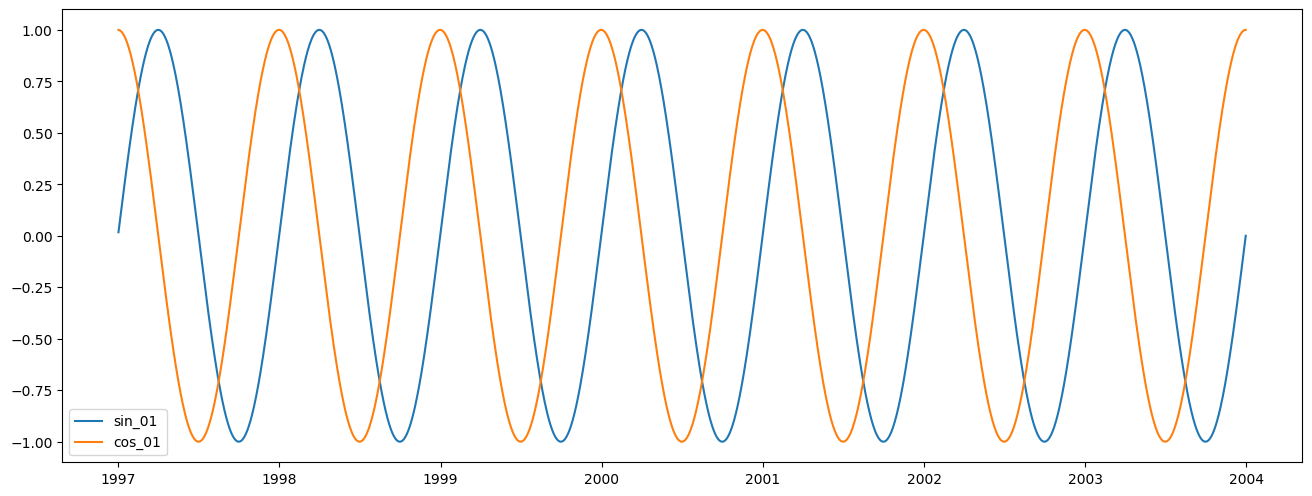

In [41]:
plot_series([dfFull[dfFull.date.dt.year<2004].sin_01,dfFull[dfFull.date.dt.year<2004].cos_01],None)

In [42]:
# Fit 10 models, up to maxFreq=10
sm_seasModel = [None]
results = [None]
for freq in range(1,1+maxFreq): 
    components_TL = [(('sin_%02d'%f),('cos_%02d'%f)) for f in range(1,1+freq)]
    components = [component for pair in components_TL for component in pair]
    sm_seasModel.append(OLS(dfFull.temperature,sm.add_constant(dfFull[components]),missing='drop'))
    results.append(sm_seasModel[-1].fit())


In [43]:
print(results[1].params)
print()
print(results[1].tvalues)
print()
print(results[1].t_test([1,0,0]))
print()
print(results[1].t_test([0,1,0]))
print()
print(results[1].t_test([0,0,1]))

const     14.466217
sin_01    -3.336496
cos_01    -9.210996
dtype: float64

const     359.668806
sin_01    -58.519676
cos_01   -162.329951
dtype: float64

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            14.4662      0.040    359.669      0.000      14.387      14.545

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -3.3365      0.057    -58.520      0.000      -3.448      -3.225

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [68]:
results[1].params['sin_01']

-3.336496188443751

In [84]:
preds = [None]
for freq in range(1,1+maxFreq): 
    thisPred = results[freq].params.const
    for f in range(1,1+freq):
        thisPred += results[freq].params['sin_%02d'%f]*dfFull['sin_%02d'%f]
        thisPred += results[freq].params['cos_%02d'%f]*dfFull['cos_%02d'%f]
    preds.append(thisPred.rename('seasModel_%02d'%freq))
residuals=[None]
for freq in range(1,1+maxFreq):
    residuals.append((dfFull.temperature - preds[freq]).rename('residuals_%02d'%freq))

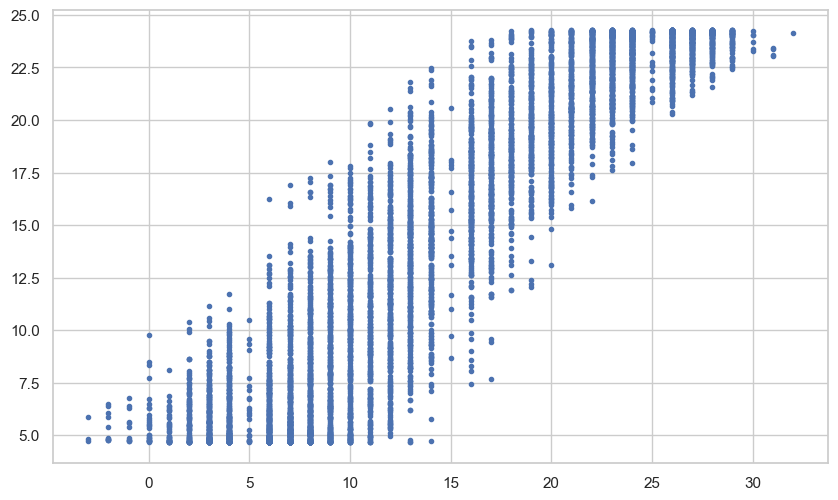

In [85]:
plt.plot(dfFull.temperature,preds[1],'.')

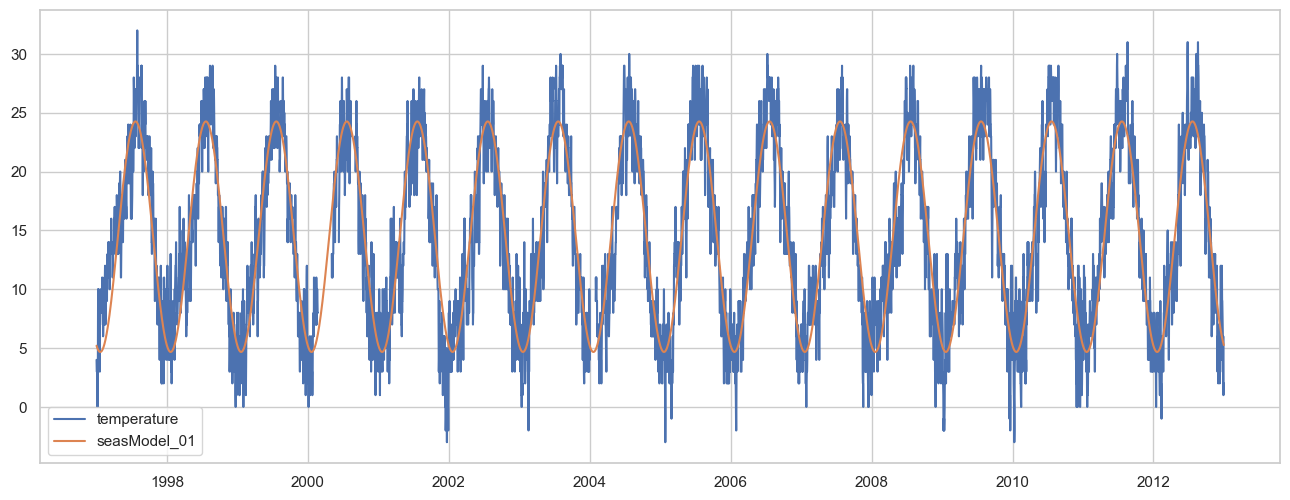

In [86]:
plot_series([dfFull.temperature,preds[1]],None)

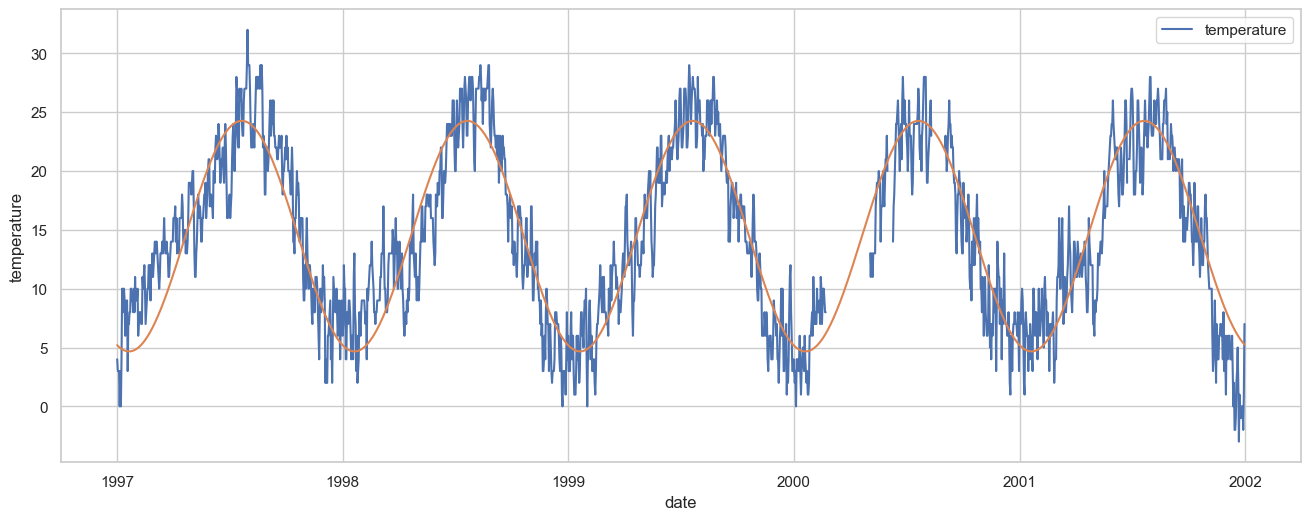

In [87]:
plot_series([dfFull[dfFull.date.dt.year<2002].temperature,pred_01[dfFull.date.dt.year<2002]],None,
                   xlabel='date',ylabel='temperature')

In [73]:
amplitude = np.sqrt(results[1].params.sin_01**2+results[1].params.cos_01**2)
phase_fraction = (np.arctan2(results[1].params.sin_01,results[1].params.cos_01)+np.pi)/(2*np.pi)
phase_day = phase_fraction*365

In [74]:
print((amplitude,phase_fraction,phase_day))
# Amplitude ~= 10 C
    # => Year Mean ~= 15 C
    # => Summer Peak ~= 25 C, Winter Peak ~= 5 C
# phase_day = 20.2 (out of 365) 
    # Winter Peak is occurring on January 21

(9.796665047699248, 0.055310809210339144, 20.188445361773788)


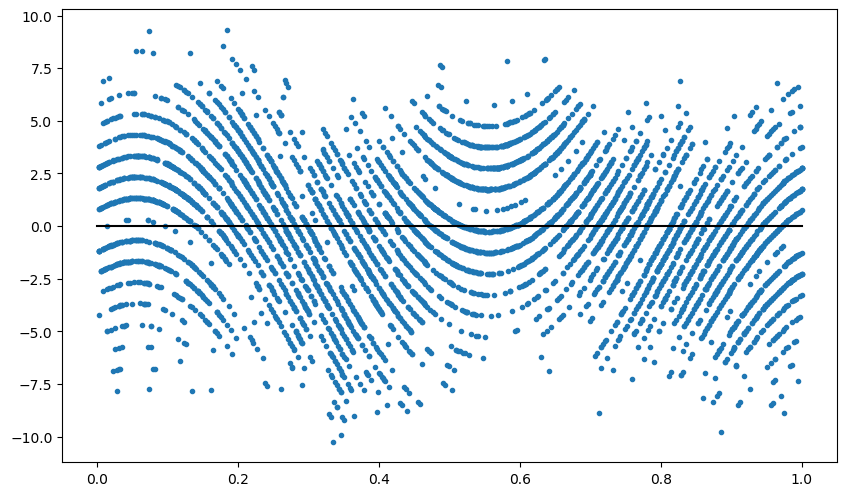

In [50]:
plt.plot(dfFull.DOY,residuals_01,'.')
plt.plot([0,1],[0,0],'k-')

In [76]:
allfreqs = range(1,11)
pd.Series([residuals[f].std() for f in allfreqs],index=allfreqs)

1     3.039416
2     2.833902
3     2.826156
4     2.824512
5     2.813841
6     2.813398
7     2.812160
8     2.810065
9     2.809284
10    2.807269
dtype: float64

In [77]:
print(dfFull.temperature.std())

7.565158527428138


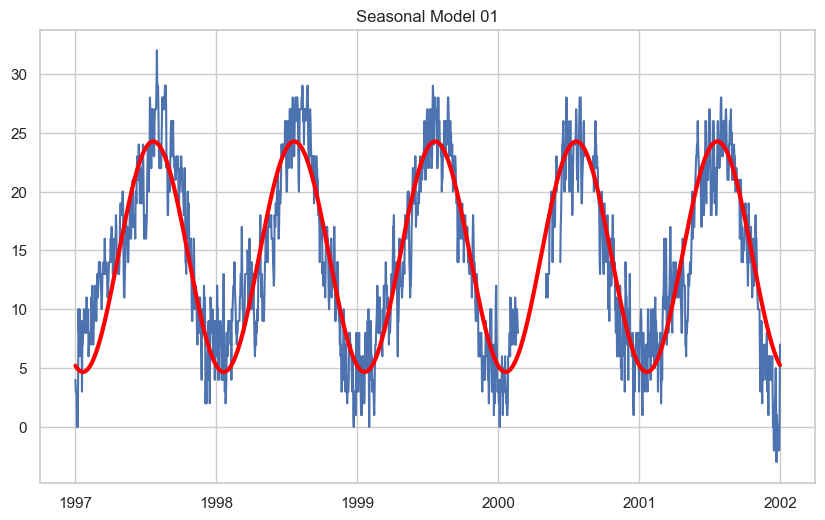

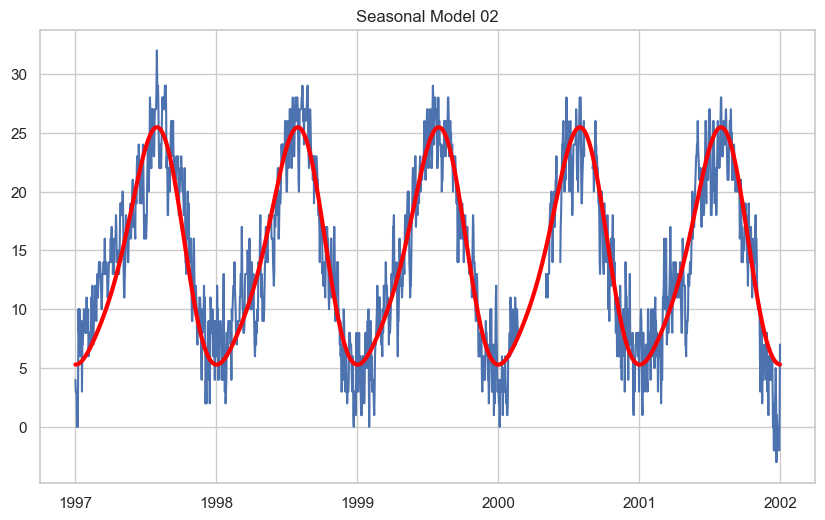

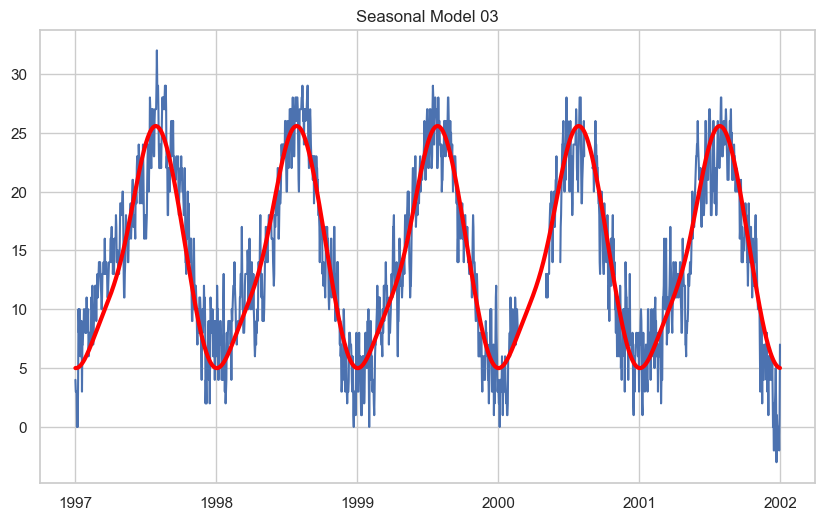

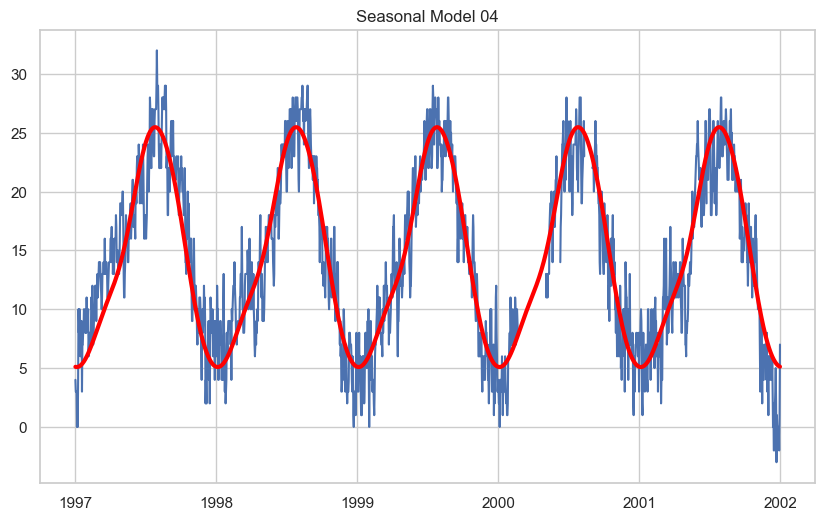

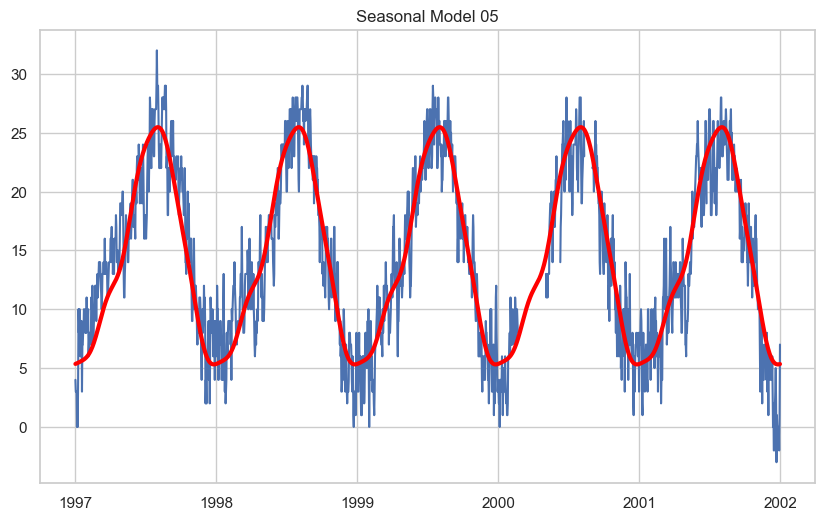

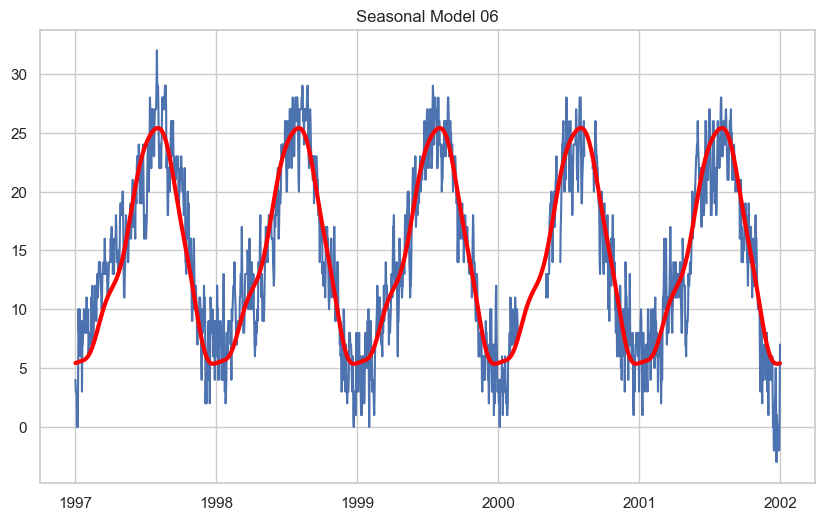

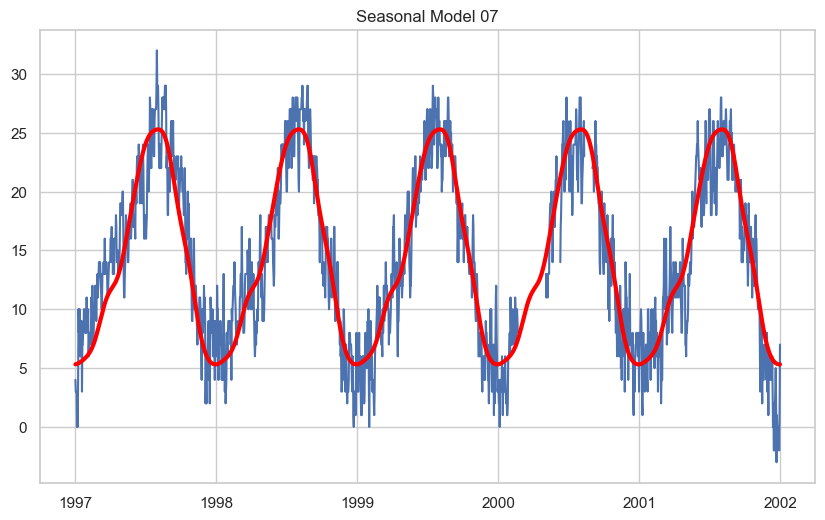

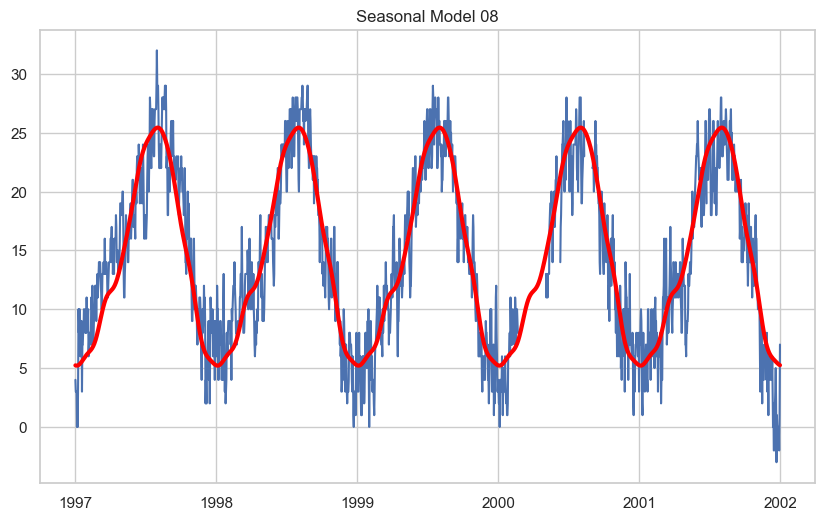

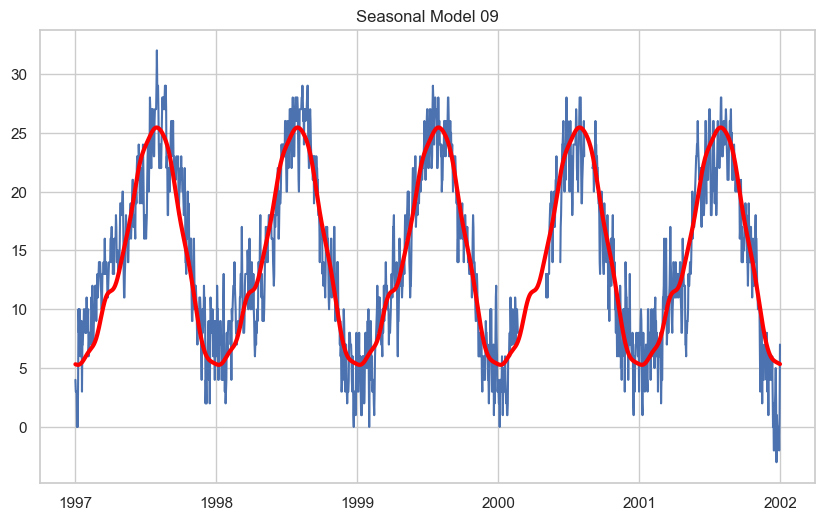

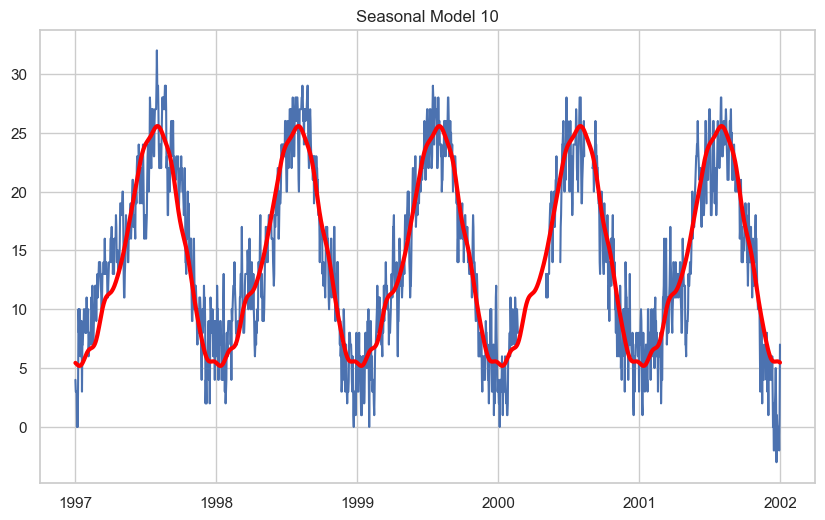

In [101]:
timeRange = (dfFull.date.dt.year<2002)
for f in allfreqs:
    plt.plot(dfFull.date[timeRange],dfFull.temperature[timeRange])
    plt.plot(dfFull.date[timeRange],preds[f][timeRange],color=[1,0,0],linewidth=3)
    plt.title('Seasonal Model %02d' % f)
    plt.show()

In [102]:
train = dfFull[dfFull.date.dt.year<2010]
val   = dfFull[dfFull.date.dt.year>=2010]

In [106]:
# Fit 10 models, up to maxFreq=10
sm_seasModel = [None]
fittedModels = [None]
for freq in range(1,1+maxFreq): 
    components_TL = [(('sin_%02d'%f),('cos_%02d'%f)) for f in range(1,1+freq)]
    components = [component for pair in components_TL for component in pair]
    sm_seasModel.append(OLS(train.temperature,sm.add_constant(train[components]),missing='drop'))
    fittedModels.append(sm_seasModel[-1].fit())

In [107]:
preds = [None]
for freq in range(1,1+maxFreq): 
    thisPred = fittedModels[freq].params.const
    for f in range(1,1+freq):
        thisPred += fittedModels[freq].params['sin_%02d'%f]*train['sin_%02d'%f]
        thisPred += fittedModels[freq].params['cos_%02d'%f]*train['cos_%02d'%f]
    preds.append(thisPred.rename('seasModel_%02d'%freq))
residuals=[None]
for freq in range(1,1+maxFreq):
    residuals.append((train.temperature - preds[freq]).rename('residuals_%02d'%freq))

In [108]:
allfreqs = range(1,11)
pd.Series([residuals[f].std() for f in allfreqs],index=allfreqs)
# Training Set RMSE:

1     3.037726
2     2.812180
3     2.799434
4     2.798518
5     2.787556
6     2.786852
7     2.784785
8     2.777734
9     2.772869
10    2.770867
dtype: float64

In [109]:
valPredictions = [None]
for freq in range(1,1+maxFreq): 
    thisPred = fittedModels[freq].params.const
    for f in range(1,1+freq):
        thisPred += fittedModels[freq].params['sin_%02d'%f]*val['sin_%02d'%f]
        thisPred += fittedModels[freq].params['cos_%02d'%f]*val['cos_%02d'%f]
    valPredictions.append(thisPred.rename('seasModel_%02d'%freq))
valResiduals=[None]
for freq in range(1,1+maxFreq):
    valResiduals.append((val.temperature - valPredictions[freq]).rename('residuals_%02d'%freq))

In [110]:
allfreqs = range(1,11)
pd.Series([valResiduals[f].std() for f in allfreqs],index=allfreqs)
# Validation Set RMSE:

1     3.034177
2     2.914295
3     2.931586
4     2.928136
5     2.919014
6     2.920021
7     2.922835
8     2.948685
9     2.972436
10    2.971613
dtype: float64

Validation performance suggests that we're overfitting at model 03 and beyond.

Therefore, we will choose model 02 for our seasonal variation.

# Auto-Regressive Model

We have lowered RMSE to 3 with the seasonality model. Variation above and beyond the seasonality should be auto-regressive, so we can improve our prediction by adding the most recent daily measurements to the model.

Exploration earlier suggests that this auto-regression is very unlikely to require more than three days recent measurements.

Try to predict the residuals (after seasonality) using linear models AR(1), AR(2), and AR(3) 

In [114]:
# Here is a useful visualization function for time series
    # adapted from http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax,linestyle='none',marker='o',markersize=4)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax,alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [119]:
residuals[2]

1997-01-01   -1.339618
1997-01-02   -2.343185
1997-01-03   -2.349313
1997-01-04   -2.357951
1997-01-05   -5.369048
                ...   
2009-12-27   -1.361949
2009-12-28    2.648035
2009-12-29    6.655212
2009-12-30    5.659630
2009-12-31    1.661337
Freq: D, Name: residuals_02, Length: 4748, dtype: float64

In [124]:
cleanSelection = pd.Series(residuals[2].index>pd.Timestamp('2004-02-01'),index=residuals[2].index)

In [123]:
pd.Series(residuals[2].index>pd.Timestamp('2004-02-01'),index=residuals[2].index)

1997-01-01    False
1997-01-02    False
1997-01-03    False
1997-01-04    False
1997-01-05    False
              ...  
2009-12-27     True
2009-12-28     True
2009-12-29     True
2009-12-30     True
2009-12-31     True
Freq: D, Length: 4748, dtype: bool

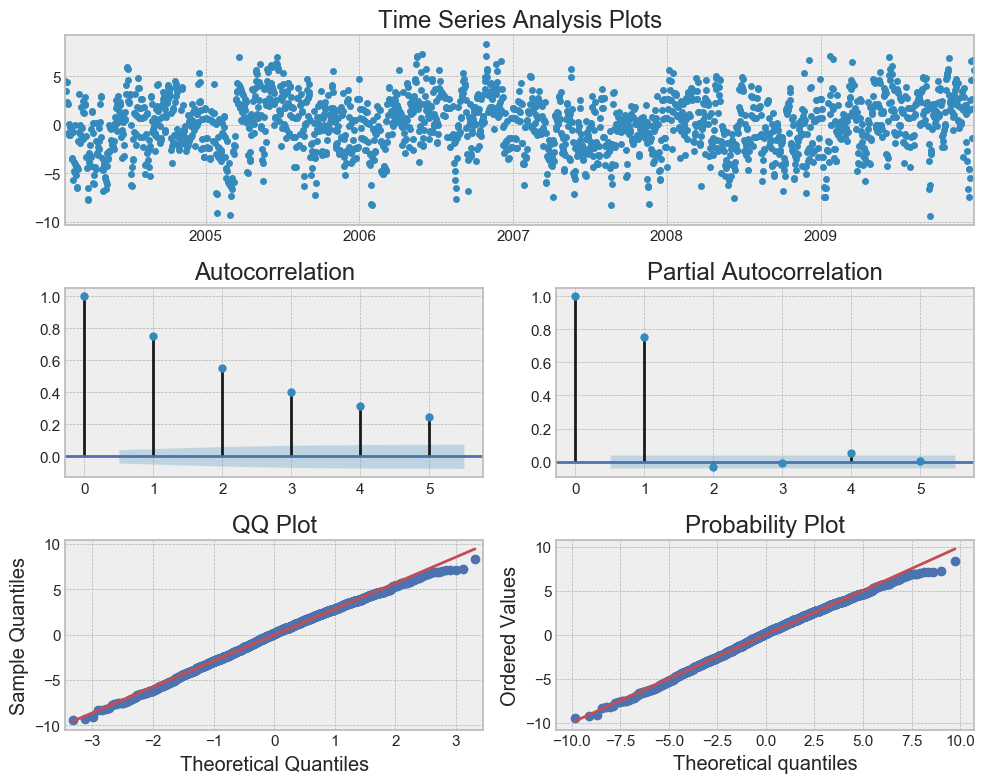

In [125]:
tsplot(residuals[2][cleanSelection], lags=5)

### This is Strong Evidence for AR(1) being sufficient

In [126]:
def tsXYScatter(timeseries,lag):
    X=timeseries[:(-lag or None)]
    Y=timeseries[lag:]
    plt.scatter(X,Y)
    plt.title('Scatterplot: Lag = %d' % lag)

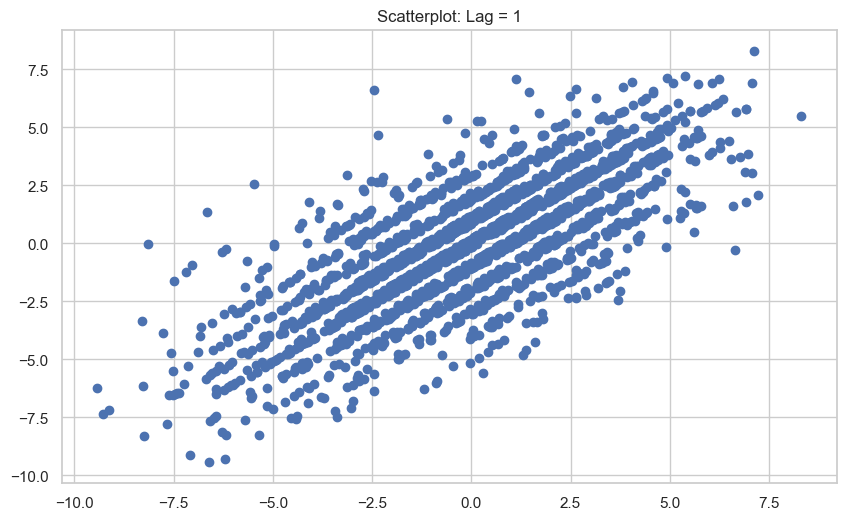

In [127]:
tsXYScatter(residuals[2][cleanSelection],lag=1)

AR(1) is just another OLS linear model with a single predictor. 

In [141]:
X = residuals[2][cleanSelection].iloc[:-1]
y = residuals[2][cleanSelection].iloc[1:]

In [142]:
y

2004-02-03    3.480390
2004-02-04    4.419657
2004-02-05    4.357965
2004-02-06    2.295347
2004-02-07    2.231838
                ...   
2009-12-27   -1.361949
2009-12-28    2.648035
2009-12-29    6.655212
2009-12-30    5.659630
2009-12-31    1.661337
Freq: D, Name: residuals_02, Length: 2159, dtype: float64

In [150]:
AR1 = OLS(pd.Series(list(y),index=X.index),sm.add_constant(pd.DataFrame(X)),missing='drop')
ar1_results = AR1.fit()

In [152]:
ar1_results.params

const          -0.010598
residuals_02    0.753198
dtype: float64

In [154]:
final_predictions_train = X*ar1_results.params.residuals_02 + ar1_results.params.const
final_residuals_train = y-final_predictions_train

In [155]:
final_residuals_train.std()

0.706701082444069

In [156]:
final_residuals_train.abs().mean()

0.570991985664692

In [ ]:
# Better than expected

In [168]:
final_predictions_val = pd.Series(list(valResiduals[2].iloc[:-1])) *ar1_results.params.residuals_02 + ar1_results.params.const
final_residuals_val = pd.Series(list(valResiduals[2].iloc[1:]))-final_predictions_val

In [169]:
final_predictions_val

0       1.239999
1       0.484114
2      -1.026898
3       1.979389
4       1.971031
          ...   
1090    0.460460
1091   -2.542718
1092    0.477554
1093   -3.283061
1094   -2.526553
Length: 1095, dtype: float64

In [170]:
valResiduals[2].iloc[1:]

2010-01-02    0.656815
2010-01-03   -1.349313
2010-01-04    2.642049
2010-01-05    2.630952
2010-01-06    0.617449
                ...   
2012-12-27   -3.361824
2012-12-28    0.648105
2012-12-29   -4.344756
2012-12-30   -3.340362
2012-12-31   -3.338663
Freq: D, Name: residuals_02, Length: 1095, dtype: float64

In [171]:
final_predictions_val

0       1.239999
1       0.484114
2      -1.026898
3       1.979389
4       1.971031
          ...   
1090    0.460460
1091   -2.542718
1092    0.477554
1093   -3.283061
1094   -2.526553
Length: 1095, dtype: float64

In [172]:
final_residuals_val

0      -0.583184
1      -1.833427
2       3.668947
3       0.651563
4      -1.353582
          ...   
1090   -3.822284
1091    3.190824
1092   -4.822310
1093   -0.057301
1094   -0.812110
Length: 1095, dtype: float64

In [174]:
final_residuals_val.abs().mean()

1.4954645518413183

# Apply to Test Set:

In [177]:
test_df

,date,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,events,winddirection,DOY,Year_f
5717,2013-01-01,9.0,6.0,3.0,6.0,4.0,2.0,100.0,93.0,76.0,1024,1021,1018,11.0,7.0,2.0,10,5,23.0,1.02,4.0,Rain,154,0.002740,2013.002740
5718,2013-01-02,11.0,6.0,0.0,3.0,2.0,0.0,100.0,81.0,42.0,1029,1026,1024,31.0,6.0,0.0,37,10,NaN,0.00,4.0,Fog,12,0.005479,2013.005479
5719,2013-01-03,13.0,7.0,0.0,2.0,-1.0,-5.0,93.0,66.0,30.0,1039,1034,1028,31.0,31.0,31.0,10,5,NaN,0.00,NaN,NaN,12,0.008219,2013.008219
5720,2013-01-04,12.0,4.0,-3.0,1.0,-2.0,-5.0,93.0,70.0,36.0,1043,1038,1036,31.0,31.0,31.0,8,5,NaN,0.00,NaN,NaN,350,0.010959,2013.010959
5721,2013-01-05,12.0,4.0,-3.0,2.0,-1.0,-4.0,100.0,81.0,49.0,1040,1034,1031,31.0,15.0,6.0,10,5,NaN,0.00,NaN,NaN,351,0.013699,2013.013699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807,2015-12-27,14.0,7.0,-1.0,6.0,2.0,-2.0,100.0,77.0,30.0,1035,1030,1027,31.0,14.0,5.0,14,6,NaN,0.00,8.0,Fog,38,0.989041,2015.989041
6808,2015-12-28,15.0,8.0,2.0,8.0,4.0,1.0,100.0,78.0,34.0,1031,1027,1023,31.0,14.0,8.0,27,8,45.0,0.51,7.0,Rain,243,0.991781,2015.991781
6809,2015-12-29,11.0,8.0,5.0,9.0,7.0,5.0,100.0,89.0,66.0,1034,1030,1026,31.0,9.0,0.0,14,8,32.0,2.03,5.0,Fog-Rain,190,0.994521,2015.994521
6810,2015-12-30,9.0,8.0,6.0,7.0,6.0,5.0,93.0,87.0,70.0,1034,1029,1025,19.0,10.0,6.0,14,5,34.0,0.00,6.0,NaN,256,0.997260,2015.997260


In [178]:
for freq in [1,2]:
    test_df['sin_%02d'%freq] = np.sin(2*np.pi*test_df.DOY*freq)
    test_df['cos_%02d'%freq] = np.cos(2*np.pi*test_df.DOY*freq)

In [179]:
test_df.head()

,date,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,events,winddirection,DOY,Year_f,sin_01,cos_01,sin_02,cos_02
5717,2013-01-01,9.0,6.0,3.0,6.0,4.0,2.0,100.0,93.0,76.0,1024,1021,1018,11.0,7.0,2.0,10,5,23.0,1.02,4.0,Rain,154,0.002740,2013.002740,0.017213,0.999852,0.034422,0.999407
5718,2013-01-02,11.0,6.0,0.0,3.0,2.0,0.0,100.0,81.0,42.0,1029,1026,1024,31.0,6.0,0.0,37,10,NaN,0.00,4.0,Fog,12,0.005479,2013.005479,0.034422,0.999407,0.068802,0.997630
5719,2013-01-03,13.0,7.0,0.0,2.0,-1.0,-5.0,93.0,66.0,30.0,1039,1034,1028,31.0,31.0,31.0,10,5,NaN,0.00,NaN,NaN,12,0.008219,2013.008219,0.051620,0.998667,0.103102,0.994671
5720,2013-01-04,12.0,4.0,-3.0,1.0,-2.0,-5.0,93.0,70.0,36.0,1043,1038,1036,31.0,31.0,31.0,8,5,NaN,0.00,NaN,NaN,350,0.010959,2013.010959,0.068802,0.997630,0.137279,0.990532
5721,2013-01-05,12.0,4.0,-3.0,2.0,-1.0,-4.0,100.0,81.0,49.0,1040,1034,1031,31.0,15.0,6.0,10,5,NaN,0.00,NaN,NaN,351,0.013699,2013.013699,0.085965,0.996298,0.171293,0.985220


In [201]:
test_seasonality = fittedModels[2].params.const \
                    + fittedModels[2].params.sin_01*test_df.sin_01 \
                    + fittedModels[2].params.cos_01*test_df.cos_01 \
                    + fittedModels[2].params.sin_02*test_df.sin_02 \
                    + fittedModels[2].params.cos_02*test_df.cos_02

In [220]:

testPredictions = test_seasonality[1:] \
                    + ar1_results.params.residuals_02 * \
                    (pd.Series(list(test_df.temperature.iloc[:-1]),index=test_df.index[1:])-test_seasonality[1:]) \
                    + ar1_results.params.const

In [221]:
testPredictions

5718    5.827299
5719    5.828812
5720    6.584142
5721    4.327285
5722    4.330618
          ...   
6807    5.831930
6808    6.582664
6809    7.334091
6810    7.333001
6811    7.332580
Length: 1094, dtype: float64

In [222]:
testResiduals = (test_df.temperature.iloc[1:] - testPredictions)

In [223]:
testResiduals.std()

1.8895622107973746

In [224]:
testResiduals.abs().mean()

1.4782095930250756

# Extra Stuff

In [175]:
# Can run Ljung-Box test to determine independence of final residuals:

In [128]:
[smQ,smP] = sm_acorr_ljungbox(residuals[2][cleanSelection],lags=30)

C:\Users\rek\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [129]:
[smQ,smP]

[array([1226.68842921, 1888.37718738, 2237.22860777, 2451.17909565,
        2585.07854601, 2671.06515656, 2733.32850678, 2774.91535076,
        2805.78462807, 2831.60640446, 2859.03744544, 2884.4892137 ,
        2903.21368884, 2918.46560182, 2933.24722856, 2947.61853258,
        2954.37105975, 2960.702308  , 2966.38783115, 2974.76573868,
        2990.68798346, 3014.65024888, 3039.50903678, 3063.56054035,
        3091.04032668, 3122.41516147, 3164.9913811 , 3204.00959259,
        3233.76405648, 3249.12563021]),
 array([9.66521898e-269, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.0

# Missing Data

In [130]:
# Possibly a helpful library from R

https://cran.r-project.org/web/packages/imputeTS/imputeTS.pdf